# Import relevant packages

In [143]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import ta
from binance.client import Client
client = Client()

# Get Data Function

In [144]:
# Download data
def getdata(symbol, start, end):
    frame = pd.DataFrame(client.get_historical_klines(symbol,'1h', start, end))
    frame = frame.iloc[:,:6]
    frame.columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
    frame.set_index('Time', inplace = True)
    frame.index = pd.to_datetime(frame.index, unit = 'ms')
    frame = frame.astype(float)
    return frame

In [145]:
data_start_date = '2022-01-01' # Change this variable to get more data
data_end_date = '2022-12-31'

df = getdata('BTCUSDT', data_start_date, data_end_date)
df.info()
df.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8737 entries, 2022-01-01 00:00:00 to 2022-12-31 00:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    8737 non-null   float64
 1   High    8737 non-null   float64
 2   Low     8737 non-null   float64
 3   Close   8737 non-null   float64
 4   Volume  8737 non-null   float64
dtypes: float64(5)
memory usage: 409.5 KB


,Open,High,Low,Close,Volume
Time,,,,,
2022-12-30 20:00:00,16525.91,16571.51,16523.91,16568.69,6253.72281
2022-12-30 21:00:00,16569.36,16677.35,16568.31,16585.06,8873.19505
2022-12-30 22:00:00,16585.06,16597.00,16577.57,16583.27,3950.19324
2022-12-30 23:00:00,16582.81,16618.75,16568.00,16607.48,4986.34147
2022-12-31 00:00:00,16607.48,16616.37,16578.00,16580.32,4264.25848


# Get Levels Function


In [146]:
def get_levels(date):
    ratios = [-0.618 , 0.618, 1.618]
    series = df.loc[date:][1:2].squeeze()
    diff = series.High - series.Low
    levels = [i * diff + series.Low for i in ratios]
    
    return levels

# Fixing up data & Implementation of backtest

In [147]:
# Get unique dates so that we can iterate through it later
dates = np.unique(df.index.date)

# Create price column such that the price for execution for a datarow is the next data row's open
df['price'] = df.Open.shift(-1)

In [148]:
buys, sells = [], []
trade_dates = []

in_position = False

for date in dates:
    for index, row in df[date:][2:].iterrows():
        if not in_position:
            sl, entry, tp = get_levels(date)
            if row.Close >= entry:
                buys.append(row.price)
                trade_dates.append(date)
                in_position = True
        
        if in_position:
            if row.Close >= tp or row.Close <= sl:
                sells.append(row.price)
                in_position = False
                break

In [149]:
# Create a df for buying and selling prices
trades = pd.DataFrame([buys, sells])
trades.columns = trade_dates # Set the columns to dates that trades were taken
trades.index = ['Buy', 'Sell'] # Set row index to buy and sell
trades = trades.T # Transpose data

trades['PnL'] = trades.Sell - trades.Buy # Create column with PnL for the trades
trades['PnL_rel'] = trades.PnL / trades.Buy # Create % of profit column

In [164]:
months = np.unique(df.index.month)
years = np.unique(df.index.year)

for date, trade in trades.iterrows():
    for month in months:
        


array([2022], dtype=int64)

# Results

### Using Algorithm

In [150]:
# Cumulative of % change
cum_series = (trades.PnL_rel + 1).cumprod()
print('PnL for algo would be: {} %'.format(round((cum_series[-1] - 1)*100, 2)))

PnL for algo would be: 54.85 %


### If we just held the trade

In [151]:
buy_price = df.iloc[0].Open
sell_price = df.iloc[-1].Close
PnL_rel = (sell_price - buy_price) / buy_price
print('PnL for holding would be: {} %'.format(round(PnL_rel*100, 2)))

PnL for holding would be: -64.13 %


# Visualisation

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

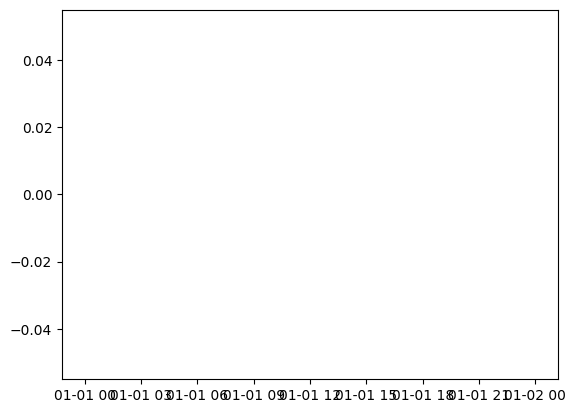

In [152]:
date = '2023-01-01'

# Extracting first trading hour of the day to find Fibonacci values
series = df.loc[date:][1:2].squeeze()

# Calculating difference to multiply by fibonacci ratios
diff_ = series.High - series.Low

# Fib ratios
ratios_ = [-0.618, 0.618, 1.618] # SL, Entry, TP Ratios

# Actual price @ ratios
levels_ = [i * diff_ + series.Close for i in ratios_]

# Visualise Data
plt.plot(df.loc[date:][:25].Close) # Plot first 25 rows of data from date (all data of first day)

# Plot horizontal lines
colors = ['k', 'g', 'b']

for i in range(3):
    plt.axhline(y = levels_[i], color = colors[i], linestyle = '-' )

plt.figure(figsize = (15,3))
